# Lasagne Tutorial

_This tutorial assumes basic knowledge of Theano.  [Here](http://nbviewer.ipython.org/github/craffel/theano-tutorial/blob/master/Theano%20Tutorial.ipynb) is a Theano tutorial if you need to get up to speed._

Theano is increadibly useful for compiling and automatically differentiating symbolic expressions transparently on a CPU or GPU.  While it is designed with the application of large neural networks in mind, it has relatively little functionality towards that end.  [Lasagne](https://github.com/benanne/Lasagne/) is a Python module built on top of Theano which provides useful blocks which make building neural network models simple.  It has been designed to extend Theano's functionality, so it generally follows Theano's conventions and methods typically accept and return Theano expressions.  In this way, it makes constructing commonly used network structures easy but also allows for arbitrary/unconventional models.  It's also meant to provide a reference implementation which is highly optimized.

Development of Lasagne is ongoing and it is still in pre-release stages.  However, it's been built up enough that there is plenty of useful code and new features and are constantly being added.  It's currently being developed by a diverse group of researchers with different applications in mind, which ensures that it is both generic and coherent.

Using gpu device 0: GeForce GTX 780 Ti


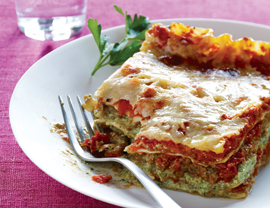

In [1]:
import theano
import theano.tensor as T
import lasagne
import numpy as np
import sklearn.datasets
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
IPython.display.Image("http://static-vegetariantimes.s3.amazonaws.com/wp-content/uploads/2009/03/10851medium.jpg")

In [2]:
# Lasagne is pre-release, so it's interface is changing.
# Whenever there's a backwards-incompatible change, a warning is raised.
# Let's ignore these for the cours of the tutorial
import warnings
warnings.filterwarnings('ignore', module='lasagne')

## Toy example

As a toy example to demonstrate functionality, we'll train a standard multi-layer perceptron on a simple synthetic two-dimensional four-class dataset.

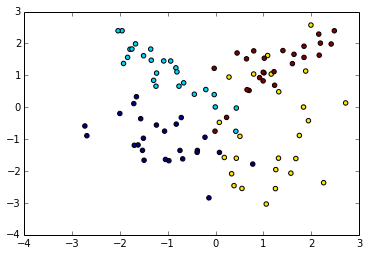

In [3]:
# Generate synthetic data
N_CLASSES = 4
X, y = sklearn.datasets.make_classification(n_features=2, n_redundant=0,
                                            n_classes=N_CLASSES, n_clusters_per_class=1)
# Convert to theano floatX
X = X.astype(theano.config.floatX)
# Labels should be ints
y = y.astype('int32')
# Make a scatter plot where color encodes class
plt.scatter(X[:, 0], X[:, 1], c=y)

### Ingredients: `layers`

What is lasagne made out of?  A stack of layers of noodles, sauce, cheeses, etc.  Just like baking lasagne, constructing a network in Lasagne typically involves stacking `Layer` subclass instances.  Much of Lasagne's functionality centers around subclasses of the `Layer` class.  A typical `Layer` subclass is an implementation of some kind of commonly used neural network layer, and contains the layer's parameters as well as methods for computing the (symbolic) output given some (symbolic) input.  Most `Layer`s are initialized with an input layer.  The output of the network can be generated using the final layer's `get_output` method, which recursively computes a symbolic Theano expression for the output of all layers given an input.  

#### `InputLayer`

The class `InputLayer` is a special layer type which stops the recurision and allows the user to input actual data into the network.  It also, for convenience, instantiates a Theano tensor variable `input_var` of the right type given the shape you provide it.  It's used by default to compute the symbolic Theano expression of the network (see below).

In [4]:
# First, construct an input layer.
# The shape parameter defines the expected input shape, which is just the shape of our data matrix X.
l_in = lasagne.layers.InputLayer(shape=X.shape)

#### `DenseLayer`

The `DenseLayer` is the basic building block of the neural network: It computes a linear mix of the input $x$ using a weight matrix $W$ and a bias vector $b$, and then applies a nonlinearity $\sigma$, yielding $\sigma(Wx + b)$.  The `DenseLayer` class keeps track of the parameters and how to use them to compute this expression.

In [5]:
# We'll create a network with two dense layers: A tanh hidden layer and a softmax output layer.
l_hidden = lasagne.layers.DenseLayer(
    l_in,  # The first argument is the input layer
    num_units=10,  # This defines the layer's output dimensionality
    nonlinearity=lasagne.nonlinearities.tanh)  # Various nonlinearities are available
# For our output layer, we'll use a dense layer with a softmax nonlinearity.
l_output = lasagne.layers.DenseLayer(l_hidden, num_units=N_CLASSES, 
                                     nonlinearity=lasagne.nonlinearities.softmax)

#### `get_output`

To actually compute the Theano expression of a stack of `Layer` subclass instances, use the `get_output` function of the final layer.  As mentioned above, with no arguments, `get_output` will compute the output given the input variable `input_var` of the `InputLayer` at the base of the network.  You can also pass a Theano symbolic variable to get the output of the network with respect to that variable instead.  *N.b. - `get_output` will soon be changed to a global function instead of a layer method, see https://github.com/Lasagne/Lasagne/pull/182*

In [6]:
# Now, we can generate the symbolic expression of the network's output
net_output = l_output.get_output()

### Tasting: `objectives`

When making lasagne, you need a way to decide when lasagne is ready to eat.  A talented lasagne cook can do this by tasting it.  Machine learning practitioners use objective functions to decide when their neural network has been successfuly trained.  Lasagne's `objectives.Objective` class provides a convenient way to compute a symbolic Theano expression for an objective function.  Usually this involves comparing the output of a network to a true value.

In [7]:
# As a loss function, we'll use Theano's categorical_crossentropy function.
# This allows for the network output to be class probabilities,
# but the target output to be class labels.
true_output = T.ivector('true_output')
objective = lasagne.objectives.Objective(l_output,
        loss_function=lasagne.objectives.categorical_crossentropy)
# get_loss computes a Theano expression for the objective, given a target variable
# By default, it will use the network's InputLayer input_var, which is what we want.
loss = objective.get_loss(target=true_output)

### Baking: `updates`

After assembling a lasagna and deciding when it's ready to eat, you still need to bake it.  Getting a neural network ready to use is done by optimizing its parameters with respect to the objective.  Lasagne crucially provides functionality for constructing updates to optimize the networks parameters according to some objective (i.e. train it).  This makes it easy to, for example, train a network with stochastic gradient descent (or something more fancy like AdaGrad).  Computing the updates typically involves collecting the network's parameters using `get_all_params` then using a function in `lasagne.updates`.  The resulting updates list can then be fed into a `theano.function` to train the network.

In [8]:
# Retrieving all parameters of the network is done using get_all_params,
# which recursively collects the parameters of all layers connected to the provided layer.
all_params = lasagne.layers.get_all_params(l_output)
# Now, we'll generate updates using Lasagne's SGD function
updates = lasagne.updates.sgd(loss, all_params, learning_rate=1)
# Finally, we can compile Theano functions for training and computing the output.
# Note that because loss depends on the input variable of our input layer,
# we need to retrieve it and tell Theano to use it.
train = theano.function([l_in.input_var, true_output], loss, updates=updates)
get_output = theano.function([l_in.input_var], net_output)

In [9]:
# Train (bake?) for 100 epochs
for n in xrange(100):
    train(X, y)

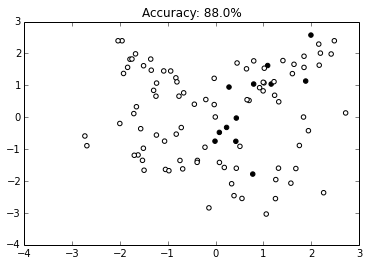

In [10]:
# Compute the predicted label of the training data.
# The argmax converts the class probability output to class label
y_predicted = np.argmax(get_output(X), axis=1)
# Plot incorrectly classified points as black dots
plt.scatter(X[:, 0], X[:, 1], c=(y != y_predicted), cmap=plt.cm.gray_r)
# Compute and display the accuracy
plt.title("Accuracy: {}%".format(100*np.mean(y == y_predicted)))

## Real-world example (MNIST ConvNet)

The above example illustrates the simplest possible usage of Lasagne.  Fortunately, it's also useful for real-world problems.  Here, we'll train a convolutional network to classify MNIST digits.  This example is based on the [`mnist_conv.py`](https://github.com/benanne/Lasagne/blob/master/examples/mnist_conv.py) script included with Lasagne.

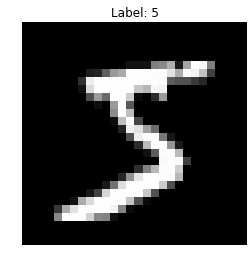

In [11]:
# We'll use the load_data function from the mnist.py example
from mnist import _load_data
data = _load_data()

# Convert the data from the pickle file into a dict
# The keys will be 'train', 'valid', and 'test'
subsets = ['train', 'valid', 'test']
# Each entry will be a dict with 'X' and 'y' entries
# for the data and labels respectively.
dataset = {}
for (subset_data, subset_labels), subset_name in zip(data, subsets):
    # The data is provided in the shape (n_examples, 784)
    # where 784 = width*height = 28*28
    # We need to reshape for convolutional layer shape conventions - explained below!
    subset_data = subset_data.reshape(
        (subset_data.shape[0], 1, 28, 28))
    dataset[subset_name] = {
        # We need to use data matrices of dtype theano.config.floatX
        'X': subset_data.astype(theano.config.floatX),
        # Labels are integers
        'y': subset_labels.astype(np.int32)}

# Plot an example digit with its label
plt.imshow(dataset['train']['X'][0][0], interpolation='nearest', cmap=plt.cm.gray)
plt.title("Label: {}".format(dataset['train']['y'][0]))
plt.gca().set_axis_off()

### ConvNet Input

In Lasagne, the convention for a 2D convolutional network is that the data's shape throughout the network is `(n_examples, n_channels, width, height)`.  Since MNIST digits has a single channel (they're grayscale images), `n_channels = 1` for the input layer; if we were dealing with RGB images we'd have `n_channels = 3`.  Within the network, `n_channels` is the number of filter kernels of each layer.

Conveniently, we can make the first dimension (the "number of example" dimension) variable.  This comes in handy when you pass your network training examples in minibatches, but want to evaluate the output on the entire validation or test set.  This is designated by setting the first entry of the shape passed to the `InputLayer` to `None`.

In [12]:
# We'll determine the input shape from the first example from the training set.
input_shape = dataset['train']['X'][0].shape
l_in = lasagne.layers.InputLayer(
    shape=(None, input_shape[0], input_shape[1], input_shape[2]))

### Convolutional layers

The basic 2D convolutional layer in Lasagne is `Conv2DLayer`.  This uses Theano's built-in convolution operation to convolve a collection 2D filter against the last two dimensions of its inputs.  Lasagne also provides hooks to the cuda-convnet and cuDNN convolution backends; see `lasagne.layers.cuda_convnet` and `lasagne.layers.dnn` respectively.

#### Note on parameter initialization

The initialization used for each parameter in each layer can be a Numpy `ndarray`, a Theano shared variable, or an `Initializer` subclass from `lasagne.init`.  Many common initialization schemes are included in Lasagne for convenience.  For example, below we'll be initializing the convolutional layer weights using the approach proposed by He et. al. in ["Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"](http://arxiv.org/abs/1502.01852).  This approach initializes the weights by sampling a Gaussian distribution with zero mean and $\sigma = \sqrt{\frac{2}{n\_in}}$, where $n\_in$ is the number of inputs to the layer.

In [13]:
# Create the first convolutional layer
l_conv1 = lasagne.layers.Conv2DLayer(
    l_in,
    # Here, we set the number of filters and their size.
    num_filters=32, filter_size=(5, 5),
    # lasagne.nonlinearities.rectify is the common ReLU nonlinearity
    nonlinearity=lasagne.nonlinearities.rectify,
    # Use He et. al.'s initialization
    W=lasagne.init.HeNormal(gain='relu'))
# Other arguments: Convolution type (full, same, or valid) and stride

### Pooling layers

2D max pooling is straightforward: Use the `MaxPool2DLayer`.  As with the convolutional layer, there are cuda-convnet and cuDNN versions, too.

In [14]:
# Here, we do 2x2 max pooling.  The max pooling layer also supports striding
l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))

In [15]:
# The second convolution/pooling pair is the same as above.
l_conv2 = lasagne.layers.Conv2DLayer(
    l_pool1, num_filters=32, filter_size=(5, 5),
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))
l_pool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2, 2))

### Dense layers

We'll be using a single hidden layer and a dense output layer with dropout in between.  As is the convention in convnets, the hidden layer will use a ReLU nonlinearity.

In [16]:
l_hidden1 = lasagne.layers.DenseLayer(
    l_pool2, num_units=256, 
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))

### Dropout

Dropout in Lasagne is implemented as a `Layer` subclass.  By placing a `DropoutLayer` between layers, the connections between the two layers will randomly be dropped.  As we'll see later, setting `get_output`'s keyword argument `deterministic` to `True` will make the `DropoutLayer` act as a simple pass-through, which is useful when computing the output of the network after training.

In [17]:
l_hidden1_dropout = lasagne.layers.DropoutLayer(l_hidden1, p=0.5)

In [18]:
l_output = lasagne.layers.DenseLayer(
    l_hidden1_dropout,
    # The number of units in the softmas output layer is the number of classes.
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

### Objectives, updates, and training

This part of the code will look very similar to above - we'll define an objective, compute some updates, use the updates to compile Theano functions, then use the functions to train the network and compute its output given some input.

In [19]:
true_output = T.ivector('true_output')
objective = lasagne.objectives.Objective(l_output,
        loss_function=lasagne.objectives.categorical_crossentropy)

# As mentioned above, when using dropout we should define different losses:
# One for training, one for evaluation.  The training loss should apply dropout,
# while the evaluation loss shouldn't.  This is controlled by setting the deterministic kwarg.
loss_train = objective.get_loss(target=true_output, deterministic=False)
loss_eval = objective.get_loss(target=true_output, deterministic=True)

all_params = lasagne.layers.get_all_params(l_output)
# Since this problem is a little harder than our toy example,
# let's use a fancier stochastic optimization technique: Adadelta.
updates = lasagne.updates.adadelta(loss_train, all_params)
train = theano.function([l_in.input_var, true_output], loss_train, updates=updates)

# This is the function we'll use to compute the network's output given an input
# (e.g., for computing accuracy).  Again, we don't want to apply dropout here
# so we set the deterministic kwarg to True.
get_output = theano.function([l_in.input_var], l_output.get_output(deterministic=True))

In [21]:
# Now, let's train it!  We'll chop the training data into mini-batches, and validate every epoch.
BATCH_SIZE = 100
N_EPOCHS = 10
# Keep track of which batch we're training with
batch_idx = 0
# Keep track of which epoch we're on
epoch = 0
while epoch < N_EPOCHS:
    # Extract the training data/label batch and update the parameters with it
    train(dataset['train']['X'][batch_idx:batch_idx + BATCH_SIZE],
          dataset['train']['y'][batch_idx:batch_idx + BATCH_SIZE])
    batch_idx += BATCH_SIZE
    # Every pass over the training data (epoch)
    if batch_idx >= dataset['train']['X'].shape[0]:
        # Reset the batch index
        batch_idx = 0
        # Update the number of epochs trained
        epoch += 1
        # Compute the network's on the validation data
        val_output = get_output(dataset['valid']['X'])
        # The predicted class is just the index of the largest probability in the outpu
        val_predictions = np.argmax(val_output, axis=1)
        # The accuracy is the average number of correct predictions
        accuracy = np.mean(val_predictions == dataset['valid']['y'])
        print("Epoch {} validation accuracy: {}".format(epoch, accuracy))

Epoch 1 validation accuracy: 0.9795
Epoch 2 validation accuracy: 0.9852
Epoch 3 validation accuracy: 0.9871
Epoch 4 validation accuracy: 0.9891
Epoch 5 validation accuracy: 0.9905
Epoch 6 validation accuracy: 0.9905
Epoch 7 validation accuracy: 0.99
Epoch 8 validation accuracy: 0.992
Epoch 9 validation accuracy: 0.9896
Epoch 10 validation accuracy: 0.9906


## Recurrent Networks

Development of recurrent layers in Lasagne is ongoing in [this fork](https://github.com/craffel/nntools).  Currently, classes for a customizable recurrent layer an a LSTM layer have been implemented.  The layers can be set to run forwards or backwards on their input sequences.  A great deal of effort has been placed on making these layers as efficient as possible, although at present the LSTM layer is still slower than `currennt`, a CUDA-based library.